# Description 

#### Pycaret documentation
https://pycaret.org/regression/

#### Run inconda env pycaret2_alex

### ToDo
1. test full dataset for individual pixels

## Imports 

In [11]:
#import regression module 
from pycaret.regression import * 

import pandas as pd
%config Completer.use_jedi = False

In [64]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [482]:
import datetime
import tqdm

## Setting and Setup

#### Data 

In [532]:
PATH_DATA = r'data/INSITU_vs_SAT.csv'
#PATH_DATA = r'data/INSITU_SAT_ALL_PIXELS.csv'
MODEL_PATH = r'models/a254_2021-03-11'

#### Regression 

In [372]:
TARGET = 'a254'
DATA_COLS = ['time', 'Rw400', 'Rw412', 'Rw443', 'Rw490', 'Rw510', 'Rw560',
       'Rw620', 'Rw665', 'Rw674', 'Rw681', 'Rw709', 'Rw754', 'Rw779', 'Rw865',
       'Rw1020']

## Data Loading and preprocessing 

In [373]:
df = pd.read_csv(PATH_DATA)

In [374]:
df

,time,n,Rw400,Rw412,Rw443,Rw490,Rw510,Rw560,Rw620,Rw665,...,Rw754,Rw779,Rw865,Rw1020,ratio,cdom440,cdom375,a254,a350,a443
0,2018-05-30,20,0.010117,0.007851,0.009023,0.011803,0.015951,0.035293,0.032618,0.027384,...,0.012502,0.010208,0.005799,0.001353,2.639883,0.005973,-0.022636,57.289490,14.757243,3.633730
1,2018-05-31,37,0.004514,0.004369,0.004935,0.006927,0.009673,0.018504,0.021040,0.023322,...,0.012732,0.012021,0.007698,0.010300,3.422013,0.020040,0.040916,65.533020,17.227237,4.391385
2,2018-06-01,54,0.002090,0.002488,0.004565,0.006881,0.009211,0.017073,0.022303,0.025289,...,0.014699,0.013754,0.008828,0.011552,3.677898,0.021601,0.048001,73.776550,19.697230,5.149040
3,2018-06-03,36,0.002980,0.003100,0.005143,0.006235,0.008854,0.017334,0.024193,0.029256,...,0.020082,0.019581,0.014587,0.022014,4.312529,0.025584,0.065802,106.558525,28.445500,7.063755
4,2018-06-04,8,0.000987,-0.000062,0.004218,0.010010,0.014556,0.025882,0.038078,0.045455,...,0.049468,0.047743,0.049196,0.050280,4.541117,0.026205,0.068659,122.949512,32.819635,8.021113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2020-10-10,140,0.008314,0.005839,0.003979,0.004928,0.007497,0.018200,0.018025,0.016693,...,0.012171,0.010751,0.005347,0.007422,3.230043,0.008138,-0.012202,NaN,NaN,NaN
272,2020-10-11,281,0.007198,0.006148,0.005128,0.005403,0.009196,0.018730,0.017499,0.015186,...,0.008802,0.007811,0.003230,0.006138,2.847090,0.006223,-0.020943,NaN,NaN,NaN
273,2020-10-13,287,0.005680,0.005283,0.004264,0.004973,0.007928,0.016990,0.017220,0.015693,...,0.009356,0.008404,0.003999,0.010798,3.158948,0.008898,-0.008870,NaN,NaN,NaN
274,2020-10-15,31,0.396156,0.404947,0.412507,0.412356,0.422882,0.442493,0.442679,0.439721,...,0.438599,0.437722,0.435817,0.465139,1.066362,0.010357,-0.047030,NaN,NaN,NaN


In [375]:
df.columns

Index(['time', 'n', 'Rw400', 'Rw412', 'Rw443', 'Rw490', 'Rw510', 'Rw560',
       'Rw620', 'Rw665', 'Rw674', 'Rw681', 'Rw709', 'Rw754', 'Rw779', 'Rw865',
       'Rw1020', 'ratio', 'cdom440', 'cdom375', 'a254', 'a350', 'a443'],
      dtype='object')

#### Adapt datatypes

In [376]:
df.time = pd.to_datetime(df.time)

## Model comparison 
model setup - ET often best/one of best models
  -  to be tested on hold_out set

In [377]:
val_year = 2020
df_filt = (df.query('n > 0')[DATA_COLS + [TARGET]]).dropna()
df_train = df_filt[df.time.dt.year !=val_year]
df_val = df_filt[df.time.dt.year ==val_year]

In [354]:
experiment = setup(df_train, target=TARGET, 
                   remove_multicollinearity=False, 
                   fold_strategy='timeseries', 
                   date_features=['time'],
                   transformation=False,
                   remove_outliers=False, 
                   silent=True,
                   normalize=False,
                   pca=False,
                   verbose=False)
models_compare = compare_models(sort='RMSE', exclude=['huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,9.2123,148.9913,11.8313,0.8514,0.1780,0.1439,0.0180
rf,Random Forest Regressor,9.3193,159.5951,12.1303,0.8425,0.1834,0.1470,0.1180
ada,AdaBoost Regressor,10.0615,179.6299,12.9288,0.8230,0.2010,0.1616,0.0220
dt,Decision Tree Regressor,10.1299,221.1427,14.1166,0.7761,0.2043,0.1492,0.0140
et,Extra Trees Regressor,11.5260,217.6106,14.2205,0.7789,0.2174,0.1786,0.1020
omp,Orthogonal Matching Pursuit,12.3106,229.0920,14.8472,0.7646,0.2334,0.2003,0.0140
lasso,Lasso Regression,12.2535,232.6627,15.0627,0.7604,0.2352,0.1975,0.0130
ridge,Ridge Regression,13.6326,262.4990,15.9660,0.7268,0.2470,0.2220,0.0140
br,Bayesian Ridge,13.8393,273.5502,16.1697,0.7181,0.2549,0.2263,0.0120
knn,K Neighbors Regressor,13.7471,283.0473,16.3140,0.6984,0.2613,0.2375,0.0250


### Annual Cross validation 

In [527]:
def ts_cv(df, val_year=2020, model_type='rf'):
    #val_year = 2020
    df_train = df[df.time.dt.year !=val_year]
    #df_train = df_train[df_train.n > 200]
    df_train = (df_train[DATA_COLS + [TARGET]]).dropna()
    #df_val = df_filt[df.time.dt.year ==val_year]
    df_val = df[df.time.dt.year ==val_year].dropna()
    experiment = setup(df_train, target=TARGET, 
                       remove_multicollinearity=True, 
                       fold_strategy='timeseries', 
                       date_features=['time'],
                       transformation=False,
                       remove_outliers=False, 
                       silent=True,
                       normalize=False,
                       pca=False,
                       verbose=False)
    model = create_model(model_type,verbose=False, cross_validation=False)
    trained = predict_model(model, data=df_train)
    predicted = predict_model(model, data=df_val)
    return predicted

In [526]:
df_cleaned = (df[DATA_COLS + [TARGET]]).dropna()
predictions = []
for val_year in tqdm.tqdm_notebook([2018, 2019, 2020]):
    predictions.append(ts_cv(df, val_year=val_year, model_type='rf'))
final_prediction = pd.concat(predictions)
print('RMSE val:', metrics.mean_squared_error(final_prediction[TARGET], final_prediction['Label'])**0.5)

  0%|          | 0/3 [00:00<?, ?it/s]

RMSE val: 15.48210591519646


### Plot  

True cross-validated results
- fold 1: train 2018, 2019 - val 2020
- fold 2: train 2018, 2020 - val 2019
- fold 3: train 2019, 2020 - val 2018

**Label**: predicted value

**a254**: ground-truth/in-situ measurements

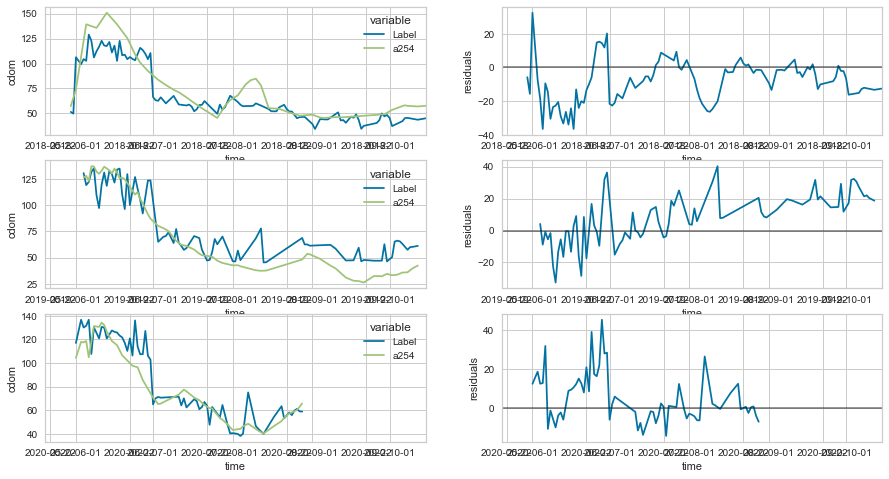

In [528]:
fig, ax = plt.subplots(figsize=(15,8), nrows=3, ncols=2)
# upper
r = 0
year = 2018
for year in [2018, 2019, 2020]:
    ix = final_prediction.time.dt.year == year
    df_melt = pd.melt(final_prediction.loc[ix], value_vars=['Label', TARGET], value_name='cdom', id_vars='time')
    sns.lineplot(data=df_melt, x='time', y='cdom', hue='variable', ax=ax[r, 0])
    #ax[r,0].set_title(f'Measured vs modelled: {TARGET}')
    ax[r, 0].set_xlim([datetime.date(year, 5, 20), datetime.date(year, 10, 15)])
    ax[r, 1].set_xlim([datetime.date(year, 5, 20), datetime.date(year, 10, 15)])

    #lower
    final_prediction['residuals'] = final_prediction['Label'] - final_prediction[TARGET]
    sns.lineplot(data=final_prediction.loc[ix], x='time', y='residuals', ax = ax[r,1])
    ax[r, 1].axhline(0, c='k', alpha=.5)
    
    r+=1

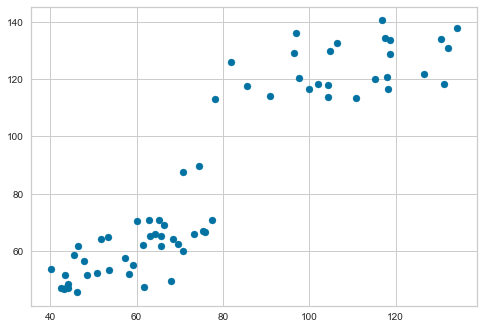

In [468]:
p = plt.scatter(predicted[TARGET], predicted.Label)

### Save final model 

In [535]:
df_train = (df[DATA_COLS + [TARGET]]).dropna()
experiment = setup(df_train, target=TARGET, 
                   remove_multicollinearity=True, 
                   fold_strategy='timeseries', 
                   date_features=['time'],
                   transformation=False,
                   remove_outliers=False, 
                   silent=True,
                   normalize=False,
                   pca=False,
                   verbose=False)
model = create_model('rf', verbose=False, cross_validation=False)
model_final = finalize_model(model)

In [536]:
save_model(model_final, MODEL_PATH)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='a254',
                                       time_features=['time'])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samples=None,
                             